<h1 id="Contents">Contents<a href="#Contents"></a></h1>
        <ol>
        <ol><li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Introduction">Introduction</a></li>
<li><a class="" href="#The-Yee-Algorithm">The Yee Algorithm</a></li>
<ol><li><a class="" href="#Update-Equations-in-1D">Update Equations in 1D</a></li>
<ol><li><a class="" href="#Courant-Number">Courant Number</a></li>
</ol></ol><li><a class="" href="#Implementing-One-Dimensional-FDTD-Simulation">Implementing One-Dimensional FDTD Simulation</a></li>
<ol><li><a class="" href="#Bare-Bones-FDTD-Simulation">Bare-Bones FDTD Simulation</a></li>
<ol><li><a class="" href="#Animation">Animation</a></li></ol>
<li><a class="" href="#Additive-Source">Additive Source</a></li>
<li><a class="" href="#Terminating-the-Grid">Terminating the Grid</a></li>
<li><a class="" href="#Total-Field/Scattered-Field-Boundary">Total-Field/Scattered-Field Boundary</a></li>
<li><a class="" href="#Inhomogeneities">Inhomogeneities</a></li>
<li><a class="" href="#Lossy-Materials">Lossy Materials</a></li>
</ol>

## Imports


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output, Video
plt.rcdefaults()

## Introduction


The finite-difference time-domain (FDTD) method employs finite differences as approximations to both the spatial and temporal derivatives that appear in Maxwell’s equations. For a function $f(x)$, the finite difference approximation of the derivative is given by

$$
\frac{df}{dx} = \frac{f(x+\frac{h}{2}) - f(x-\frac{h}{2})}{h} + O(h^2)
$$

where $h$ is the step size.

This is more accurate than the usual approximation of the derivative, which is

$$
\frac{df}{dx} = \frac{f(x+h) - f(x)}{h} + O(h)
$$


Let's look at a simple example. The function we'll use is $ f(x) = x^3 -2x^2 + x + 1 $. The derivative is $ \frac{df}{dx} = 3x^2 - 4x + 1 $.


In [66]:
def f(x):
    return x ** 3 - 2 * x ** 2 + x


In [67]:
def df(x):
    return 3 * x ** 2 - 4 * x + 1


In [68]:
point = 2
hs = np.linspace(0.01, 0.2, 1000)
errors1 = np.zeros(len(hs))
errors2 = np.zeros(len(hs))

for i, h in enumerate(list(hs)):
    diff1 = np.abs((f(point + h) - f(point)) / h)
    diff2 = np.abs((f(point + h / 2) - f(point - h / 2)) / (h))
    actual_diff = df(point)
    errors1[i] = (diff1 - actual_diff) * 100 / actual_diff
    errors2[i] = (diff2 - actual_diff) * 100 / actual_diff


In [69]:
plt.rcdefaults()


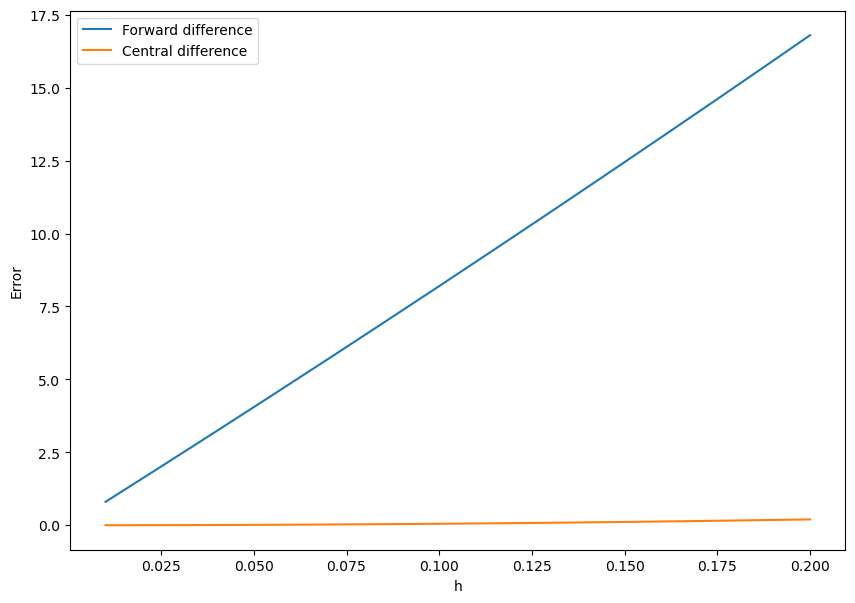

In [70]:
plt.figure(figsize=(10, 7))
plt.plot(hs, errors1, label="Forward difference")
plt.plot(hs, errors2, label="Central difference")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend()
plt.show()


Text(0, 0.5, 'Error')

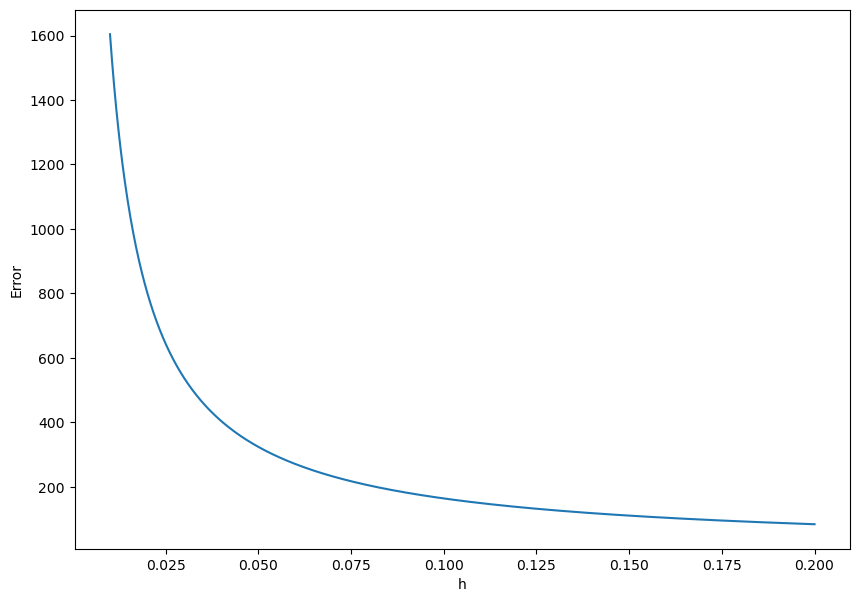

In [71]:
ratio = np.abs(errors1 / errors2)
plt.figure(figsize=(10, 7))
plt.plot(hs, ratio)
plt.xlabel("h")
plt.ylabel("Error")


Text(0, 0.5, 'Error')

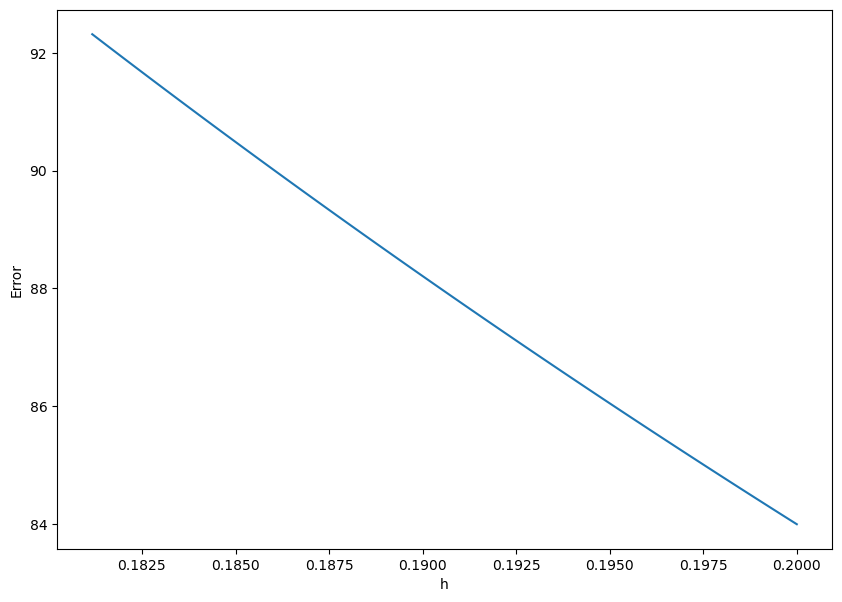

In [72]:
ratio = np.abs(errors1 / errors2)
plt.figure(figsize=(10, 7))
plt.plot(hs[-100:], ratio[-100:])
plt.xlabel("h")
plt.ylabel("Error")


We can see that even at higher value of h, the central difference approximation is still over 50 times more accurate. While for smaller value of h, the accuracy is much better.


## The Yee Algorithm


The FDTD algorithm as first proposed by Kane Yee in 1966 employs second-order central differences. The algorithm can be summarized as follows:

1. Replace all the derivatives in Ampere’s and Faraday’s laws with finite differences. Discretize
   space and time so that the electric and magnetic fields are staggered in both space and time.
2. Solve the resulting difference equations to obtain “update equations” that express the (unknown) future fields in terms of (known) past fields.
3. Evaluate the magnetic fields one time-step into the future so they are now known (effectively
   they become past fields).
4. Evaluate the electric fields one time-step into the future so they are now known (effectively
   they become past fields)


### Update Equations in 1D


The Faraday's law and Ampere's law in 1D are:

$$
\mu \frac{\partial H_y}{\partial t} = \frac{\partial E_z}{\partial x}\\
\epsilon \frac{\partial E_z}{\partial t} = \frac{\partial H_y}{\partial x}
$$


We'll use the first equation to advance the magnetic field in time and the second equation to advance the electric field. For this, we need to replace the derivatives with their finite differences. First step is to discretize space and time. We'll use

$$
E_z(x, t) = E_z(m\Delta _x, q\Delta _t) = E_z^q[m]\\
\text{and } H_y(x, t) = H_y(m\Delta _x, q\Delta _t) = H_y^q[m]
$$

where $m$ and $q$ are the spatial and temporal discretization steps.


Even though we are using a single dimension, time can be treated as a second dimension. This way, the electric and magnetic field nodes are staggered in time and space as the figure shows.


![](images/1_1.png)


When implementing FDTD algorithms we will see that the spatial indices are used as
array indices while the temporal index, which is essentially a global parameter, is not explicitly
specified for each field location


In the figure, assume that all the fields below the dahsed line are known. FDTD allows us to use this information to update the fields above the dashed line one step at a time.

Using the above notation, we can rewrite the update equations for the magnetic field using Faraday's law as:

$$
\frac{H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] - H_y^{q-\frac{1}{2}}[m+\frac{1}{2}]}{\Delta _t} = \frac{E_z^q[m+1] - E_z^q[m]}{\Delta _x}
$$

Which, after solving gives:

$$
H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] = H_y^{q-\frac{1}{2}}[m+\frac{1}{2}] +\frac{\Delta _t}{\mu \Delta _x}(E_z^q[m+1] - E_z^q[m])
$$


It shows that the future value
of $H_y$ depends on only its previous value and the neighboring electric fields. After applying this update rule to all the magnetic-field nodes, the dividing line between future and past values has advanced a
half time-step. The space-time grid thus appears as the figure below.


![](images/1_2.png)


Using the Ampere's law, the update rule for electric field is:

$$
E_z^{q+1}[m] =E_z^{q}[m]+\frac{\Delta _t}{\epsilon \Delta _x}(H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] - H_y^{q+\frac{1}{2}}[m-\frac{1}{2}])
$$


Here, again, we see that the future value of $E_z$ depends on only its past value and the value of the
neighboring magnetic fields. After applying this update rule to all the electric-field nodes, the dividing line between future and past values has advanced a
half time-step. Thus after one update of E and H, the dividing line between past and future values has advanced a full time-step.


#### Courant Number


The ratio $x\Delta _x/\Delta _t$ is called the Courant number $S_c$. It is used to determine whether the time-step is too large for the numerical method to be stable. Note that energy can propagate a distance of $c\Delta _x$ in a time of $\Delta _t$. Hence, for starting, we'll use $S_c = 1$ .

Using the definition of the Courant number, we can write the contants in the update equation as:

$$
\frac{\Delta _t}{\epsilon \Delta _x} = \frac{\eta _0}{\epsilon _r}S_c\\
\frac{\Delta _t}{\mu \Delta _x} = \frac{1}{\mu _r \eta _0}S_c
$$


> Instead of treating time as a seperate dimension, we can assume that both the E and M fields are in single spatial dimension where the
> electric and magnetic fields are offset a half spatial step from each other.


![](images/1_3.png)


## Implementing One-Dimensional FDTD Simulation


We start by discretizing the space and time. We'll create two arrays, one for the electric field and one for the magnetic field, with a size of $N$ nodes. For starting, we'll use $N = 200$.


In [73]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)


We have initialized the electric and magnetic fields to zero.


Note that the elements
in the `ez` and `hy` arrays are offset from each other by a half spatial step even though the array
values will be accessed using an integer index.


![](images/1_4.png)


It is arbitrary whether one initially wishes to think of an `ez` array element as existing to the
right or the left of an hy element with the same index. Here we will assume `ez` nodes are to
the left of `hy` nodes with the same index.


Using $S_c = 1$, the update equation, in code, is:

```
hy[m] = hy[m] + (ez[m+1] - ez[m]) / imp0
ez[m+1] = ez[m] + (hy[m] - hy[m-1]) * imp0
```


here `imp0` is the impedance of free space.


These two update equations, placed in appropriate loops, are the engines that drive an FDTD
simulation. However, there are a few obvious pieces missing from the puzzle before a useful
simulation can be performed. These missing pieces include

1. Nodes at start and at end have no neighbor in one side. eg. there is no `hy[-1]` node for the `ez[0]`.

This problem can be addressed by using boundary conditions.

2. Only a constant impedance is used so only a homogeneous medium can be modeled (in this
   case free space).

This restriction can be removed by allowing the permittivity and permeability to change
from node to node.

3. As of yet there is no energy present in the field. If the fields are initially zero, they will
   remain zero forever.

To remove this restriction, we can try initializing the fields to a non-zero state. However, this
is cumbersome and typically not a good approach. Better solutions are to introduce energy via
either a hardwired source, an additive source, or a total-field/scattered-field (TFSF) boundary.


Let's take it all together too make a simulation of a wave propagating in free space.


### Bare-Bones FDTD Simulation


In [74]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
max_time = 2500
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))
for t in range(max_time):
    ez[0] = np.exp(-((t - 30) ** 2) / 100)
    # print(ez[0])
    for i in range(0, N - 1):
        hy[i] = hy[i] + (ez[i + 1] - ez[i]) / imp0
        # print(hy[i])
    for i in range(1, N):
        ez[i] = ez[i] + (hy[i] - hy[i - 1]) * imp0
    ezs[t] = ez
    hys[t] = hy


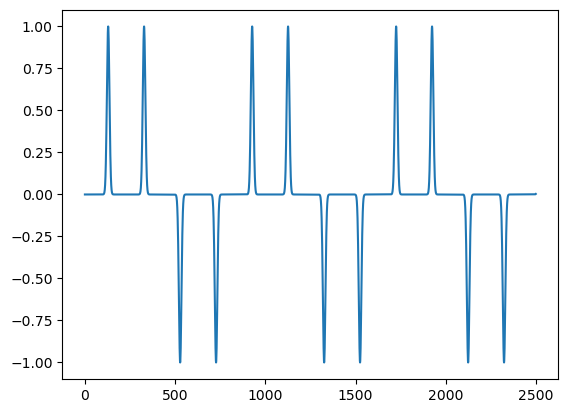

In [76]:
plt.plot(ezs[:, 100])


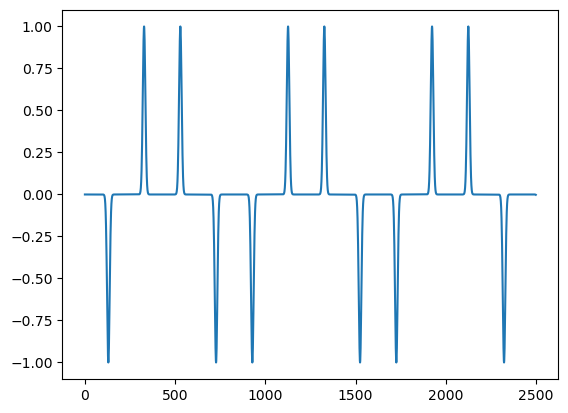

In [77]:
plt.plot(hys[:, 100] * imp0)


### Animation


In [ ]:
# Creating the Figure and Axes
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

# Setting title and axes names
plt.title("Wave in Vaccum", fontdict={"fontsize": 18})
plt.xlabel("Node", fontdict={"fontsize": 18})
plt.ylabel("Amplitude", fontdict={"fontsize": 18})
plt.xlim(0, 200)
plt.ylim(-1.1, 1.1)

# Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

# The init function
def init():
    # init lines
    for line in lines:
        line.set_data([], [])
    return lines


# Needed for adding legends
legend = plt.legend()

# The Animate function
def animate(i):
    values = np.array([ezs[i], hys[i] * imp0/2])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j == 0:
            line.set_label(fr"$E_z$ at t={i+1}")
        else:
            line.set_label(fr"{round(imp0/2,2)}$\times$ $H_y$ at t={i+1}")
    legend = plt.legend(loc="upper right")
    if (i + 1) % 50 == 0:
        print("Time", i + 1)
        clear_output(wait=True)
    return lines + [legend]


# The animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=np.arange(0, 1500), interval=40, blit=True
)

# Saving the Animation
anim.save("wave.mp4", writer="ffmpeg")


In [79]:
Video("wave.mp4")


### Additive Source


Hardwiring the source, as was done before, has the severe shortcoming that no energy can
pass through the source node. This problem can be rectified by using an additive source. Consider
Ampere’s law with the current density term:

$$
\Delta \times \mathbf{H}  = \mathbf{J} + \epsilon \frac{\partial \mathbf{E}}{\partial \mathbf{t}}
$$

Rearranging gives:

$$
\frac{\partial \mathbf{E}}{\partial \mathbf{t}} = \frac{1}{\epsilon} \Delta \times \mathbf{H}- \frac{1}{\epsilon} \mathbf{J}
$$


Going through the exact same procedure but adding the source term yields the update equation for the electric field as:

$$
E_z^{q+1}[m] =E_z^{q}[m]+\frac{\Delta _t}{\epsilon \Delta _x}(H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] - H_y^{q+\frac{1}{2}}[m-\frac{1}{2}])\\
E_z^{q+1}[m] =E_z^{q}[m]-\frac{\Delta _t}{\epsilon}J_z^{q+ \frac{1}{2}}[m]
$$


The first step of the update rule is the same as previous one. The second step is the addition of the source term. In practice the source current might only exist at a single node in the 1D grid and hence we'll need to apply the second step of the update rule just one time.


Let's implement this update equation for the electric field.


In [89]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
max_time = 1500
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))
for t in range(max_time):
    # print(ez[0])
    for i in range(0, N - 1):
        hy[i] = hy[i] + (ez[i + 1] - ez[i]) / imp0
        # print(hy[i])
    for i in range(1, N):
        ez[i] = ez[i] + (hy[i] - hy[i - 1]) * imp0
    ez[50] += np.exp((-(t - 30) * (t - 30)) / 100)
    ezs[t] = ez
    hys[t] = hy


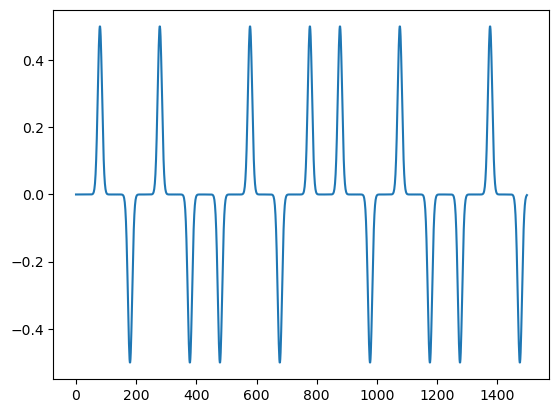

In [90]:
plt.plot(ezs[:, 100])


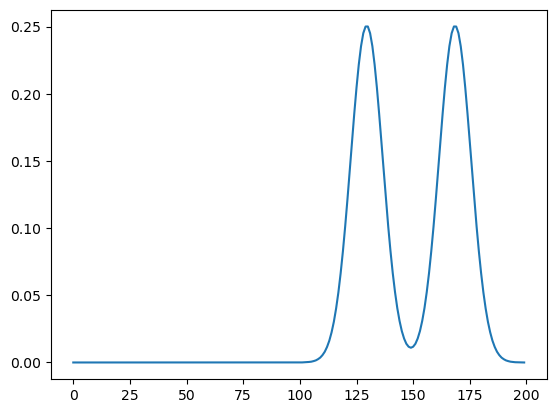

In [91]:
plt.plot(hys[249] * (imp0 / 2))


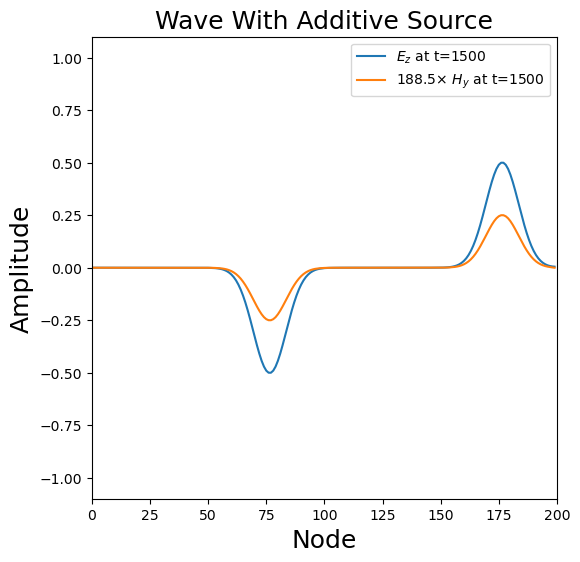

In [92]:
# Creating the Figure and Axes
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

# Setting title and axes names
plt.title("Wave With Additive Source", fontdict={"fontsize": 18})
plt.xlabel("Node", fontdict={"fontsize": 18})
plt.ylabel("Amplitude", fontdict={"fontsize": 18})
plt.xlim(0, 200)
plt.ylim(-1.1, 1.1)

# Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

# The init function
def init():
    # init lines
    for line in lines:
        line.set_data([], [])
    return lines


# Needed for adding legends
legend = plt.legend()

# The Animate function
def animate(i):
    values = np.array([ezs[i], hys[i] * imp0 / 2])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j == 0:
            line.set_label(fr"$E_z$ at t={i+1}")
        else:
            line.set_label(fr"{round(imp0/2,2)}$\times$ $H_y$ at t={i+1}")
    legend = plt.legend(loc="upper right")
    if (i + 1) % 50 == 0:
        print("Time", i + 1)
        clear_output(wait=True)
    return lines + [legend]


# The animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=np.arange(0, 1500), interval=40, blit=True
)

# Saving the Animation
anim.save("wave_with_additive_source.mp4", writer="ffmpeg")

In [93]:
Video("wave_with_additive_source.mp4")


### Terminating the Grid


Absorbing boundary
conditions (ABC’s) will be used so that the grid, which will contain only a finite number of nodes,
can behave as if it were infinite. We are interested in
modeling an open domain where there is no energy entering the grid “from the outside.” Therefore,
for node `ez[0]`, its updated value should just be the previous value that existed at `ez[1]`. Since
no energy is entering the grid from the left, the field at `ez[1]` must be propagating solely to
the left. At the next time step the value that was at `ez[1]` should now appear at `ez[0]`. Similar
arguments hold at the other end of the grid. The updated value of `hy[199]` should be the previous
value of `hy[198]`. Hence a simple ABC can be realized by adding the following line to the code written above:

```
ez[0] = ez[1]
hy[nx-1] = hy[nx-2]
```


Let's try it!


In [85]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
max_time = 1500
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))
for t in range(max_time):
    # print(ez[0])
    hy[N - 1] = hy[N - 2]
    for i in range(0, N - 1):
        hy[i] = hy[i] + (ez[i + 1] - ez[i]) / imp0
        # print(hy[i])
    ez[0] = ez[1]
    for i in range(1, N):
        ez[i] = ez[i] + (hy[i] - hy[i - 1]) * imp0
    ez[50] = np.exp((-(t - 30) * (t - 30)) / 100)
    ezs[t] = ez
    hys[t] = hy


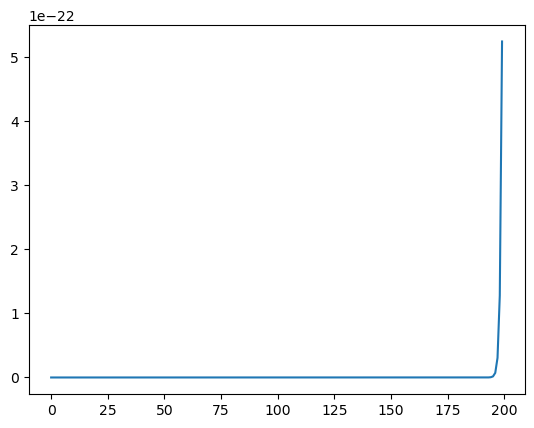

In [86]:
plt.plot(ezs[249])


In [ ]:
# Creating the Figure and Axes
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

# Setting title and axes names
plt.title("Wave With ABC", fontdict={"fontsize": 18})
plt.xlabel("Nodes", fontdict={"fontsize": 18})
plt.ylabel("Amplitude", fontdict={"fontsize": 18})
plt.xlim(0, 200)
plt.ylim(-1.1, 1.1)

# Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

# The init function
def init():
    # init lines
    for line in lines:
        line.set_data([], [])
    return lines


# Needed for adding legends
legend = plt.legend()

# The Animate function
def animate(i):
    values = np.array([ezs[i], hys[i] * imp0 / 2])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j == 0:
            line.set_label(fr"$E_z$ at t={i+1}")
        else:
            line.set_label(fr"{round(imp0/2,2)}$\times$ $H_y$ at t={i+1}")
    legend = plt.legend(loc="upper right")
    if (i + 1) % 50 == 0:
        print("Time", i + 1)
        clear_output(wait=True)
    return lines + [legend]


# The animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=np.arange(0, 800), interval=40, blit=True
)

# Saving the Animation
anim.save("wave_with_ABC.mp4", writer="ffmpeg")


In [88]:
Video("wave_with_ABC.mp4")


### Total-Field/Scattered-Field Boundary


Thus far the excitation of the FDTD grids has occurred at a point—either the
hardwired source at the left end of the grid, or the additive source at
node 50. Now our goal is to construct a source such that the excitation
only propagates in one direction, i.e., the source introduces an incident field that is propagating
to the right (the positive x direction). We will accomplish this using what is know as a totalfield/scattered-field (TFSF) boundary.

Previously the source was given by:
$$
f(t) = f(q\Delta_t)
$$
Now, we'll use $t-x/c$ instead of $t$ to construct the source. We get:
$$
t - \frac{x}{c} = q\Delta_t- \frac{m\Delta_x}{c} = (q-m)\Delta_t
$$
Here, we have assumed that the Courant number is 1.

Using this, the source term is:
$$
E_z[m, q] = e^{-\left(\frac{(q-m)-30}{10}\right)^2}
$$

The magnetic field corrsponding to this is:
$$
H_y[m, q] = -\frac{1}{\eta} e^{-\left(\frac{(q-m)-30}{10}\right)^2}
$$
The negative sign comes because we want the cross product of the electric field and the magnetic field to point in the direction of wave propagation.

In the total-field/scattered-field (TFSF) formulation, the computational domain is divided into
two regions: 
1. the total-field region which contains the incident field plus any scattered field and
2. the scattered-field region which contains only scattered field.

When updating the fields, the update equations must be consistent. This is to say only scattered
fields should be used to update a node in the scattered-field region and only total fields should be
used to update a node in the total-field region. The figure shows a one-dimensional grid where the
TFSF boundary is assumed to exist between nodes $H_y[49+\frac{1}{2}]$ and $E_z[50]$.

![](images/1_5.png)

No matter where the boundary is placed, there will only be two nodes adjacent to the boundary—
one electric-field node and one magnetic-field node. Furthermore, although the location of this
boundary is arbitrary, once its location is selected, it is fixed throughout the simulation. Defining
the scattered-field region to be to the left of the boundary and the total-field region to be to the
right, we see that `hy[49]` is the last node in the scattered-field region while `ez[50]` is the first
node in the total-field region.

When updating the nodes adjacent to the boundary, there is a problem, i.e., an inconsistency,
in that a neighbor to one side is not the same type of field as the field being updated. This is to say
that a total-field node will depend on a scattered-field node and, conversely, a scattered-field node
will depend on a total-field node. One solution to this is to modify the update equations to include the total (or scatter) field, depending on the node in the update equation for the scattered-field node. However, instead of modifying the update equation, it is usually best to preserve the standard update
equation (so that it can be put in a loop that pertains to all nodes), and then apply a correction in a
separate step. In this way, $E_z^{q+1}[50]$ is updated in a two-step process:
$$
E_z^{q+1}[50] = E_z^{q}[50] + \frac{\Delta _t}{\epsilon \Delta _x}\left(H_y^{q+\frac{1}{2}}\left[50+\frac{1}{2}\right] - H_y^{q+\frac{1}{2}}\left[50-\frac{1}{2}\right]\right)\\
E_z^{q+1}[50] = E_z^{q+1}[50] + \frac{\Delta _t}{\epsilon \Delta _x}\frac{1}{\eta}E_z^{\text{inc}}\left[50 -\frac{1}{2}, q+\frac{1}{2} \right]
$$

Using the value of $eta$ and assuming Courant number is 1, the update equation becomes:
$$
E_z^{q+1}[50] = E_z^{q+1}[50] + E_z^{\text{inc}}\left[50 -\frac{1}{2}, q+\frac{1}{2} \right]
$$
This equation simply says that the incident field that existed one-half a temporal step in the past
and one-half a spatial step to the left of $E_z^{q+1}[50]$ is added to this node. Using similar logic, the correction to magnetic field is:
$$
H_y^{q+\frac{1}{2}}\left[50+\frac{1}{2}\right] = H_y^{q+\frac{1}{2}}\left[50+\frac{1}{2}\right] + \frac{1}{\eta} E_z^{\text{inc}}\left[50 -q \right]
$$

Here is a simple example of the update equation for the electric field:

In [104]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
max_time = 1500
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))
for t in range(max_time):
    hy[N - 1] = hy[N - 2]
    for i in range(0, N - 1):
        hy[i] = hy[i] + (ez[i + 1] - ez[i]) / imp0
    # Correction to Magnetic field
    hy[49] -= np.exp(-(t - 30) * (t - 30) / 100) / imp0

    ez[0] = ez[1]
    for i in range(1, N):
        ez[i] = ez[i] + (hy[i] - hy[i - 1]) * imp0
    ez[50] += np.exp((-((t + 0.5 - (-0.5) - 30) ** 2)) / 100)
    ezs[t] = ez
    hys[t] = hy


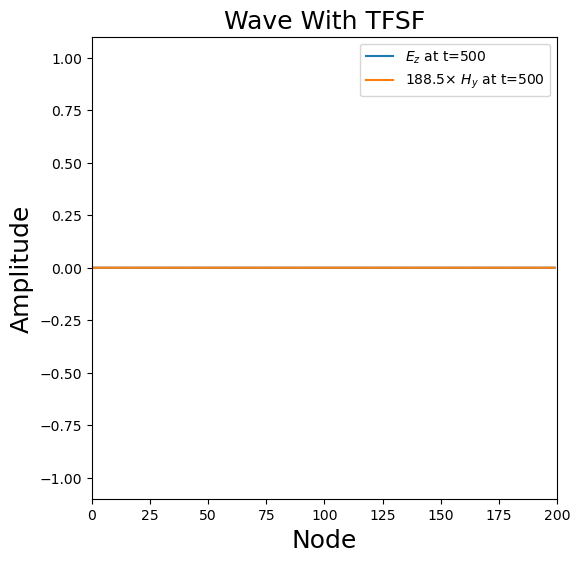

In [105]:
# Creating the Figure and Axes
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

# Setting title and axes names
plt.title("Wave With TFSF", fontdict={"fontsize": 18})
plt.xlabel("Node", fontdict={"fontsize": 18})
plt.ylabel("Amplitude", fontdict={"fontsize": 18})
plt.xlim(0, 200)
plt.ylim(-1.1, 1.1)

# Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

# The init function
def init():
    # init lines
    for line in lines:
        line.set_data([], [])
    return lines


# Needed for adding legends
legend = plt.legend()

# The Animate function
def animate(i):
    values = np.array([ezs[i], hys[i] * imp0 / 2])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j == 0:
            line.set_label(fr"$E_z$ at t={i+1}")
        else:
            line.set_label(fr"{round(imp0/2,2)}$\times$ $H_y$ at t={i+1}")
    legend = plt.legend(loc="upper right")
    if (i + 1) % 50 == 0:
        print("Time", i + 1)
        clear_output(wait=True)
    return lines + [legend]


# The animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=np.arange(0, 500), interval=30, blit=True
)

# Saving the Animation
anim.save("wave_with_TFSF.mp4", writer="ffmpeg")

In [106]:
Video("wave_with_TFSF.mp4")

### Inhomogeneities

If the values of $\epsilon$ and $\mu$ are not constant but depend on the location of the node, then the update equations must be modified. This can be done effortlessly as:

```
ez[m] = ez[m] + (hy[m] - hy[m-1])*imp0/epsR[m]
hy[m] = hy[m] + (ez[m + 1] - ez[m]) / imp0 / muR[m]

```

The following is a simulation that models a region of space near the interface between free space and a dielectric
with a relative permittivity of nine.

In [125]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
max_time = 500
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))
#Setting the epsilon values
epsR = np.ones(N)
epsR[100:] = 9.0

for t in range(max_time):
    hy[N - 1] = hy[N - 2]
    for i in range(0, N - 1):
        hy[i] = hy[i] + (ez[i + 1] - ez[i]) / imp0
    # Correction to Magnetic field
    hy[49] -= np.exp(-(t - 30) * (t - 30) / 100) / imp0

    ez[0] = ez[1]
    ez[N-1] = ez[N-2]
    for i in range(1, N):
        ez[i] = ez[i] + (hy[i] - hy[i - 1]) * imp0/epsR[i]
    ez[50] += np.exp((-((t + 0.5 - (-0.5) - 30) ** 2)) / 100)
    ezs[t] = ez
    hys[t] = hy


In [129]:
ezs[100].max(), ezs[0].min()

(0.4905329034507654, -0.00012340980408667956)

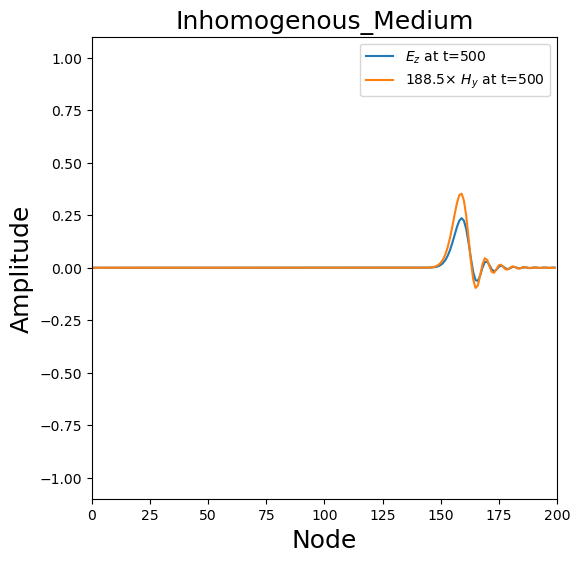

In [130]:
# Creating the Figure and Axes
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

# Setting title and axes names
plt.title("Inhomogenous_Medium", fontdict={"fontsize": 18})
plt.xlabel("Node", fontdict={"fontsize": 18})
plt.ylabel("Amplitude", fontdict={"fontsize": 18})
plt.xlim(0, 200)
margin=0.1
plt.ylim(-1.1, 1.1)

# Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

# The init function
def init():
    # init lines
    for line in lines:
        line.set_data([], [])
    return lines


# Needed for adding legends
legend = plt.legend()

# The Animate function
def animate(i):
    values = np.array([ezs[i], hys[i] * imp0 / 2])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j == 0:
            line.set_label(fr"$E_z$ at t={i+1}")
        else:
            line.set_label(fr"{round(imp0/2,2)}$\times$ $H_y$ at t={i+1}")
    legend = plt.legend(loc="upper right")
    if (i + 1) % 50 == 0:
        print("Time", i + 1)
        clear_output(wait=True)
    return lines + [legend]


# The animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=np.arange(0, 500), interval=30, blit=True
)

# Saving the Animation
anim.save("Inhomogenous_Medium.mp4", writer="ffmpeg")

In [131]:
Video("Inhomogenous_Medium.mp4")

We can see the reflection occuring at node 100 becuase of the change in the relative permittivity. The reflection coefficient for epsR=9 is 0.5, that's what we are observing. Furthermore, the velocity of the wave after entering in the dielctric medium is also reducing.

Note that when the reflected field encounters the left boundary it disappears. The ABC does its job and the field is absorbed. On the other hand, when the transmitted
wave encounters the right boundary, at approximate time = 370, it is not completely absorbed. A
reflected wave is produced. The problem that the ABC is not working is this: the simple ABC used so far is based on the assumption that the wave travels one spatial step for every time step. In this dielectric, with a relative
permittivity of 9, the speed of light is one-third that of free space and hence the wave does not
travel one spatial step per time step—it travels a third of a spatial step. A possible fix might be to update the electric field on the boundary with the value of the neighboring electric-field node from
three time steps in the past. However, what if the relative permittivity of the dielectric were 2? In
that case the speed of light would be $1/\sqrt{2}$ times that of free space. There would be no past value
of an interior node that could be used directly to update the boundary node. So, it is necessary to
rethink the implementation of the ABC so that it can handle these sorts of situations.

There is another observation: If you look at the trailing edge
of the transmitted pulse around frame 330, or so, you will see a slight wiggle. The incident field
is a Gaussian pulse which asymptotically goes to zero to either side of the peak value. However,
the transmitted pulse does not behave this way—at least not after propagating in the dielectric for
a while (initially there are no wiggles visible at the trailing edge of the transmitted pulse). These
wiggles are caused by dispersion in the FDTD grid. When the Courant number is anything other
than unity, the FDTD grid is dispersive, meaning that different frequencies propagate at different
speeds. Note that we have defined the Courant number as the $c\frac{\Delta_t}{\Delta_x}$ where c is the speed of light
in free space. We will generally maintain the convention that c represents the speed of light in
free space. However, one can think of the Courant number as a local quantity that equals the local
speed of light multiplied by the ratio $\frac{\Delta_t}{\Delta_x}$. Because the speed of light is one-third of that of free
space, the local Courant number in the dielectric is not unity. Since the Gaussian pulse consists of
a range of frequencies, and these frequencies are propagating at different speeds, the pulse “breaks
apart” as it propagates.

### Lossy Materials

When a material has a finite conductivity $\sigma$, a conduction-current term is added to Ampere’s law:
$$
\sigma \mathbf{E} + \epsilon \frac{\partial E}{\partial t}= \Delta \times \mathbf{H}
$$
which, in one dimension becomes:
$$
\sigma E_z + \epsilon \frac{\partial E_z}{\partial t}= \frac{\partial H_y}{\partial x}
$$

Expanding the equation, we'll see that the undifferentiated electric field appears on the left side of the equation. With the assumed
arrangement of the nodes, there is no electric field at the space-time point $ \left( m \Delta_x, (q+1/2)\Delta_t \right) $. This problem can be circumvented by using the averaging (in time) of the
electric field to either side of the desired point:
$$
E_z^{q+\frac{1}{2}} \approx \frac{E_z^{q+\frac{1}{2}}[m] + E_z^{q}[m]}{2}
$$

Using this and defining $\frac{\sigma \Delta_t}{2\epsilon}$ as loss, say $L$, we can write the update equation for the electric field:
$$
E_z^{q+1}[m] = \frac{1-L}{1+L} E_z^{q}[m] + \frac{\frac{2L}{\sigma}}{1+L} \left( H_y^{q+\frac{1}{2}}\left[m + \frac{1}{2}\right] - H_y^{q+\frac{1}{2}}\left[m - \frac{1}{2}\right] \right)
$$

Similarly, incorporating a magnetic comduction current, the magnetic field update equation is:
$$
H_y^{q+\frac{1}{2}}\left[m + \frac{1}{2}\right] = \frac{1-L'}{1+L'}H_y^{q-\frac{1}{2}}\left[m + \frac{1}{2}\right]+ \frac{\frac{2L'}{\sigma}}{1+L'} \left(E_z^q[m+1] - E_z^q[m] \right)
$$
here $L' = \frac{\sigma_m\Delta_t}{2\mu}$

Code below models a lossy dielectric half-space that starts at node 100. As before, the relative
permittivity is 9. However there is also an electric loss present such that $L=0.01$. The term $\frac{2L}{\sigma}$ can also be written as a ratio of impedance and dielectric constant. Also, we'll be updating just on the electric field.

In [23]:
LOSS = 0.01
N = 200
max_time = 700
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
Ez_coefficients = np.ones(N)
Hy_coefficients = np.ones(N)*imp0
Ez_coefficients[100:] = (1-LOSS)/(1+LOSS)
Hy_coefficients[100:] = imp0/9.0/(1+LOSS)
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))

for t in range(max_time):
    for i in range(0, N - 1):
        hy[i] = hy[i] + (ez[i + 1] - ez[i]) / imp0
    # Correction to Magnetic field
    hy[49] -= np.exp(-(t - 30) * (t - 30) / 100) / imp0

    ez[0] = ez[1]
    for i in range(1, N):
        ez[i] = ez[i]*Ez_coefficients[i] + (hy[i] - hy[i - 1]) * Hy_coefficients[i]
    ez[50] += np.exp((-((t + 0.5 - (-0.5) - 30) ** 2)) / 100)
    ezs[t] = ez
    hys[t] = hy

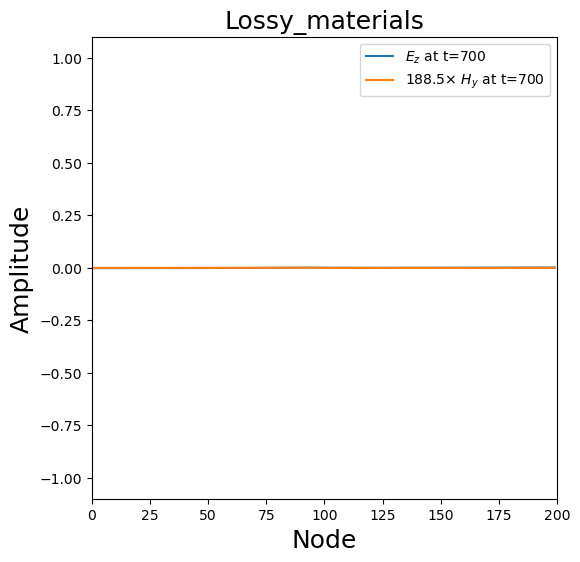

In [24]:
# Creating the Figure and Axes
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

# Setting title and axes names
plt.title("Lossy_materials", fontdict={"fontsize": 18})
plt.xlabel("Node", fontdict={"fontsize": 18})
plt.ylabel("Amplitude", fontdict={"fontsize": 18})
plt.xlim(0, 200)
margin=0.1
plt.ylim(-1.1, 1.1)

# Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

# The init function
def init():
    # init lines
    for line in lines:
        line.set_data([], [])
    return lines


# Needed for adding legends
legend = plt.legend()

# The Animate function
def animate(i):
    values = np.array([ezs[i], hys[i] * imp0 / 2])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j == 0:
            line.set_label(fr"$E_z$ at t={i+1}")
        else:
            line.set_label(fr"{round(imp0/2,2)}$\times$ $H_y$ at t={i+1}")
    legend = plt.legend(loc="upper right")
    if (i + 1) % 50 == 0:
        print("Time", i + 1)
        clear_output(wait=True)
    return lines + [legend]


# The animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=np.arange(0, 700), interval=30, blit=True
)

# Saving the Animation
anim.save("Lossy_materials.mp4", writer="ffmpeg")

In [25]:
Video("Lossy_materials.mp4")

A lossy
layer could be used to terminate the grid. The fields will dissipate in this lossy region and, if the
region is large enough, may be small by the time they encounter the end of the grid. Upon reflection
from the end of the grid, the fields would have to propagate back through the lossy layer where they
would decay even further. With proper design the reflected fields can be made inconsequentially
small when they eventually get back to the lossless portion of the grid.